# G√©n√©rateur de Noms de Domaine avec LLM
## Exp√©rimentations et √âvaluations Syst√©matiques

Ce notebook pr√©sente le d√©veloppement it√©ratif d'un syst√®me de g√©n√©ration de noms de domaine utilisant des mod√®les de langage, avec un focus sur l'√©valuation automatis√©e et la d√©couverte de cas limites.

## 1. Configuration et Imports

In [1]:
import sys
import time
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt

from langchain.prompts import PromptTemplate

# Import des modules du projet
from src.creation_dataset import CreationDataset
from src.generateur_nom_domaine import GenerateurNomsDomaine
from src.utils import charger_json, sauvegarder_json, generer_timestamp, logger, nettoyer_nom_domaine
from src.garde_fous import GardeFousSecurite, TesteurSecurite
from src.evaluateur_llm import EvaluateurLLM


print(f"Date de l'exp√©rience: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Date de l'exp√©rience: 2025-08-05 02:19:45


## 2. Cr√©ation du Dataset Synth√©tique

Nous commen√ßons par cr√©er un dataset synth√©tique diversifi√© pour l'√©valuation.

In [2]:
# Initialiser le cr√©ateur de dataset
creation_dataset = CreationDataset()

# Cr√©er le dataset complet
print("Cr√©ation du dataset synth√©tique...")
chemin_dataset = creation_dataset.sauvegarder_dataset("dataset_experimental.json")

# Charger et analyser le dataset cr√©√©
dataset_complet = charger_json(chemin_dataset)

print(f"Dataset cr√©√© avec succ√®s:")
print(f"   - Exemples d'entra√Ænement: {len(dataset_complet['entrainement'])}")
print(f"   - Cas limites: {len(dataset_complet['cas_limites'])}")

# Visualisation de la distribution des types de business
descriptions = [ex['description_business'] for ex in dataset_complet['entrainement']]
print(f"\nExemples de descriptions g√©n√©r√©es:")
for i, desc in enumerate(descriptions[:5]):
    print(f"   {i+1}. {desc}")

INFO:src.utils:G√©n√©ration d'un dataset de 1000 exemples...
INFO:src.utils:G√©n√©r√© 100/1000 exemples
INFO:src.utils:G√©n√©r√© 200/1000 exemples
INFO:src.utils:G√©n√©r√© 300/1000 exemples
INFO:src.utils:G√©n√©r√© 400/1000 exemples
INFO:src.utils:G√©n√©r√© 500/1000 exemples
INFO:src.utils:G√©n√©r√© 600/1000 exemples
INFO:src.utils:G√©n√©r√© 700/1000 exemples
INFO:src.utils:G√©n√©r√© 800/1000 exemples
INFO:src.utils:G√©n√©r√© 900/1000 exemples
INFO:src.utils:G√©n√©r√© 1000/1000 exemples
INFO:src.utils:Donn√©es sauvegard√©es dans ../data/dataset_experimental.json
INFO:src.utils:Dataset complet sauvegard√©: ../data/dataset_experimental.json
INFO:src.utils:Donn√©es charg√©es depuis ../data/dataset_experimental.json


Cr√©ation du dataset synth√©tique...
Dataset cr√©√© avec succ√®s:
   - Exemples d'entra√Ænement: 1000
   - Cas limites: 14

Exemples de descriptions g√©n√©r√©es:
   1. Nouveau centre kin√©sith√©rapie professionnel √† h√¥pital
   2. service RH dans en ligne
   3. Nouveau commerce beaut√© professionnel √† rue commer√ßante
   4. personnalis√© boutique √©lectronique dans rue commer√ßante
   5. Nouveau traiteur africain abordable √† zone commerciale


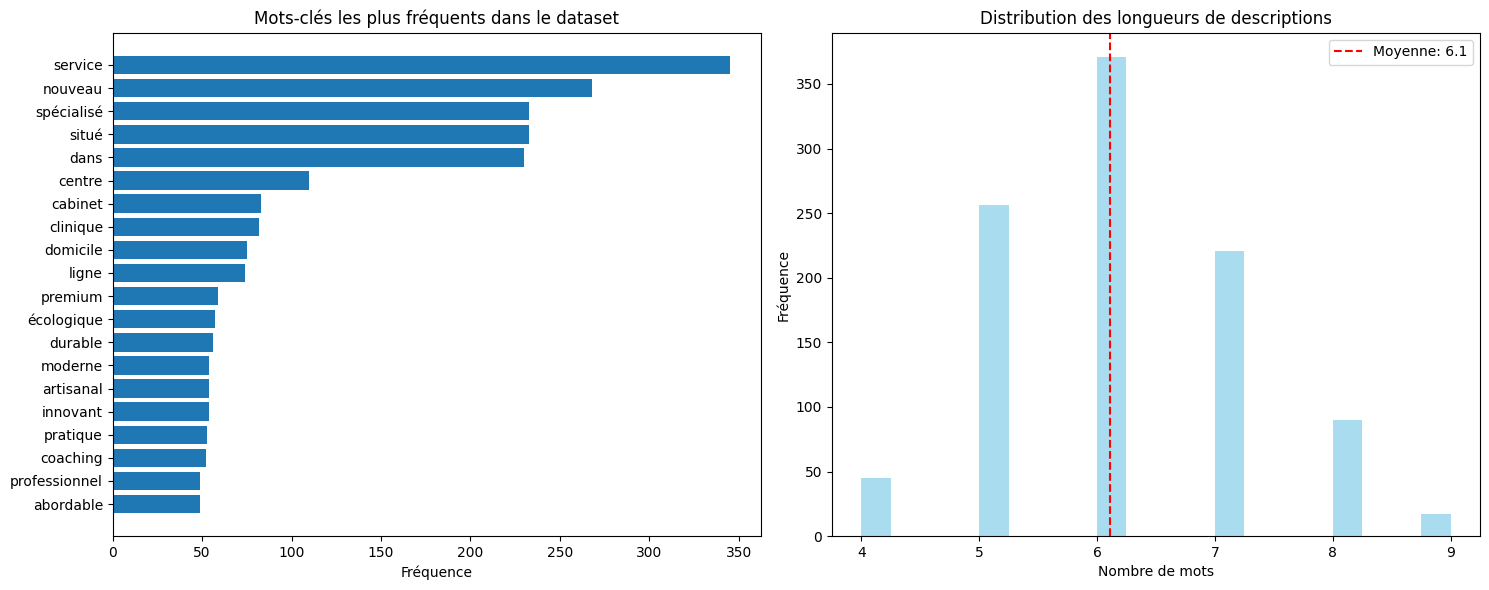

Statistiques du dataset:
   - Longueur moyenne des descriptions: 6.1 mots
   - Longueur m√©diane: 6.0 mots
   - Vocabulaire unique: 90 mots


In [3]:
# Analyser les mots-cl√©s les plus fr√©quents
tous_mots = []
for desc in descriptions:
    mots = desc.lower().split()
    tous_mots.extend([mot for mot in mots if len(mot) > 3])

mots_frequents = collections.Counter(tous_mots).most_common(20)

# Cr√©er une visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des mots les plus fr√©quents
mots, freq = zip(*mots_frequents)
ax1.barh(range(len(mots)), freq)
ax1.set_yticks(range(len(mots)))
ax1.set_yticklabels(mots)
ax1.set_xlabel('Fr√©quence')
ax1.set_title('Mots-cl√©s les plus fr√©quents dans le dataset')
ax1.invert_yaxis()

# Distribution des longueurs de descriptions
longueurs = [len(desc.split()) for desc in descriptions]
ax2.hist(longueurs, bins=20, alpha=0.7, color='skyblue')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Fr√©quence')
ax2.set_title('Distribution des longueurs de descriptions')
ax2.axvline(np.mean(longueurs), color='red', linestyle='--', label=f'Moyenne: {np.mean(longueurs):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques du dataset:")
print(f"   - Longueur moyenne des descriptions: {np.mean(longueurs):.1f} mots")
print(f"   - Longueur m√©diane: {np.median(longueurs):.1f} mots")
print(f"   - Vocabulaire unique: {len(set(tous_mots))} mots")

## 3. Initialisation du Mod√®le G√©n√©rateur

Configuration et test initial du g√©n√©rateur bas√© sur Llama3.1

In [4]:
# Initialiser le g√©n√©rateur de base
print("Initialisation du g√©n√©rateur de noms de domaine...")
try:
    generateur = GenerateurNomsDomaine(model="llama3.1", garde_fous=True, garde_fous_use_llm=False)
    info_modele = generateur.obtenir_info_modele()
    
    print("G√©n√©rateur initialis√© avec succ√®s")
    print(f"   - Mod√®le: {info_modele['nom_modele']}")
    print(f"   - URL de base: {info_modele['base_url']}")
    print(f"   - Garde-fous activ√©s: {info_modele['garde_fous_actifs']}")
    print(f"   - Styles disponibles: {', '.join(info_modele['styles_disponibles'])}")
    
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("V√©rifiez qu'Ollama est en cours d'ex√©cution et que le mod√®le llama3.1 est t√©l√©charg√©")
    print("   Commandes √† ex√©cuter:")
    print("   - ollama serve")
    print("   - ollama pull llama3.1")

INFO:src.utils:Mod√®le llama3.1 initialis√© avec succ√®s


Initialisation du g√©n√©rateur de noms de domaine...
G√©n√©rateur initialis√© avec succ√®s
   - Mod√®le: llama3.1
   - URL de base: http://localhost:11434
   - Garde-fous activ√©s: True
   - Styles disponibles: professionnel, creatif, moderne, classique, court


In [5]:
# Test initial avec des exemples vari√©s
descriptions_test = [
    "restaurant italien familial avec terrasse au centre-ville",
    "startup de d√©veloppement d'applications mobiles innovantes",
    "cabinet de conseil en marketing digital pour PME",
    "boutique de v√™tements bio et √©thiques en ligne",
    "√©cole de formation en intelligence artificielle"
]

print("Tests initiaux du g√©n√©rateur ...\n")

resultats = []

for i, description in enumerate(descriptions_test, 1):
    print(f"Test {i}/{len(descriptions_test)}: {description}")

    try:
        resultat = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        
        if resultat["status"] == "success":
            print("Suggestions g√©n√©r√©es:")
            for suggestion in resultat["suggestions"]:
                print(f"   - {suggestion['domaine']} (confiance: {suggestion['confidence']})")
            print(f"   Dur√©e: {resultat['metadata']['duree_generation_sec']}s\n")
            
            resultats.append({
                "description": description,
                "resultats": resultat
            })
        else:
            print(f"√âchec: {resultat.get('message', 'Erreur inconnue')}\n")
            
    except Exception as e:
        print(f"Erreur: {e}\n")

print(f"Tests baseline termin√©s: {len(resultats)}/{len(descriptions_test)} r√©ussis")

INFO:src.utils:G√©n√©ration de 3 | suggestions pour: restaurant italien familial avec terrasse au centr...


Tests initiaux du g√©n√©rateur ...

Test 1/5: restaurant italien familial avec terrasse au centre-ville


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: startup de d√©veloppement d'applications mobiles in...


Suggestions g√©n√©r√©es:
   - bellavista.com (confiance: 0.9)
   - terramia.fr (confiance: 0.9)
   - casabella.net (confiance: 0.8)
   Dur√©e: 26.49s

Test 2/5: startup de d√©veloppement d'applications mobiles innovantes


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: cabinet de conseil en marketing digital pour PME...


Suggestions g√©n√©r√©es:
   - apptitude.fr (confiance: 0.9)
   - mobilesphere.net (confiance: 0.8)
   Dur√©e: 44.73s

Test 3/5: cabinet de conseil en marketing digital pour PME


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: boutique de v√™tements bio et √©thiques en ligne...


Suggestions g√©n√©r√©es:
   - digitalcoachpro.com (confiance: 0.9)
   - marketeofrance.org (confiance: 0.8)
   Dur√©e: 48.9s

Test 4/5: boutique de v√™tements bio et √©thiques en ligne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: √©cole de formation en intelligence artificielle...


Suggestions g√©n√©r√©es:
   - bioethiquemode.com (confiance: 0.9)
   - vivrevert.fr (confiance: 0.9)
   - ecostylenet.org (confiance: 0.8)
   Dur√©e: 44.47s

Test 5/5: √©cole de formation en intelligence artificielle


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


Suggestions g√©n√©r√©es:
   - aiformation.com (confiance: 0.9)
   - intellilearn.fr (confiance: 0.9)
   - artificialmind.org (confiance: 0.8)
   Dur√©e: 51.46s

Tests baseline termin√©s: 5/5 r√©ussis


## 4. Impl√©mentation du Syst√®me d'√âvaluation LLM-as-a-Judge

Cr√©ation d'un √©valuateur automatique pour mesurer la qualit√© des suggestions de noms de domaine.

In [6]:
# Initialiser l'√©valuateur LLM
print("‚öñÔ∏è Initialisation du syst√®me d'√©valuation LLM-as-a-Judge...")

try:
    evaluateur = EvaluateurLLM(type_evaluateur="openai", model="gpt-4o-mini") # Pour OpenAI
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="llama3.1") # Pour Ollama ==> llma3.1
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="deepseek-r1") # Pour Ollama ==> deepseek-r1
    print("√âvaluateur initialis√© avec succ√®s")
    
    # Afficher les crit√®res d'√©valuation
    criteres = evaluateur.obtenir_criteres_evaluation()
    print("\nCrit√®res d'√©valuation:")
    for critere, description in criteres.items():
        print(f"   - {critere.capitalize()}: {description}")
        
except Exception as e:
    print(f"Erreur lors de l'initialisation de l'√©valuateur: {e}")
    print("L'√©valuateur utilisera le m√™me mod√®le que le g√©n√©rateur")

‚öñÔ∏è Initialisation du syst√®me d'√©valuation LLM-as-a-Judge...


INFO:src.utils:√âvaluateur OpenAI initialis√©: gpt-4o-mini


√âvaluateur initialis√© avec succ√®s

Crit√®res d'√©valuation:
   - Pertinence: Ad√©quation du nom de domaine √† l'activit√© d√©crite
   - Creativite: Originalit√© et m√©morabilit√© du nom
   - Memorabilite: Facilit√© de m√©morisation et de pronunciation
   - Disponibilite_estimee: Probabilit√© que le domaine soit disponible
   - Professionnalisme: Aspect professionnel et s√©rieux du nom


In [7]:
# Test du syst√®me d'√©valuation avec les r√©sultats
print("√âvaluation des r√©sultats...\n")

evaluations_baseline = []

for i, resultat_test in enumerate(resultats, 1):
    description = resultat_test["description"]
    domaines = [s["domaine"] for s in resultat_test["resultats"]["suggestions"]]
    
    print(f"√âvaluation {i}/{len(resultats)}: {description}")
    print(f"   Domaines propos√©s: {', '.join(domaines)}")
    
    try:
        evaluation = evaluateur.evaluer_suggestions(
            description_business=description,
            suggestions_domaines=domaines
        )
        
        if evaluation["status"] == "success":
            scores = evaluation["evaluations"]
            score_moyen = np.mean([s["score_total"] for s in scores])
            
            print(f"   Score moyen: {score_moyen:.2f}/10")
            
            # Afficher le d√©tail du meilleur domaine
            meilleur = max(scores, key=lambda x: x["score_total"])
            print(f"   Meilleur: {meilleur['domaine']} ({meilleur['score_total']:.1f}/10)")
            print(f"   Pertinence: {meilleur['pertinence']:.1f}, Cr√©ativit√©: {meilleur['creativite']:.1f}")
            
            evaluations_baseline.append({
                "description": description,
                "domaines": domaines,
                "evaluations": evaluation
            })
        else:
            print(f"  √âchec de l'√©valuation: {evaluation.get('message', 'Erreur inconnue')}")

    except Exception as e:
        print(f"  Erreur: {e}")

    print()

print(f"√âvaluations termin√©es: {len(evaluations_baseline)} compl√©t√©es")

√âvaluation des r√©sultats...

√âvaluation 1/5: restaurant italien familial avec terrasse au centre-ville
   Domaines propos√©s: bellavista.com, terramia.fr, casabella.net


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.40/10


   Score moyen: 7.40/10
   Meilleur: terramia.fr (8.1/10)
   Pertinence: 8.0, Cr√©ativit√©: 8.5

√âvaluation 2/5: startup de d√©veloppement d'applications mobiles innovantes
   Domaines propos√©s: apptitude.fr, mobilesphere.net


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.70/10


   Score moyen: 7.70/10
   Meilleur: apptitude.fr (8.0/10)
   Pertinence: 9.0, Cr√©ativit√©: 8.0

√âvaluation 3/5: cabinet de conseil en marketing digital pour PME
   Domaines propos√©s: digitalcoachpro.com, marketeofrance.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.60/10


   Score moyen: 6.60/10
   Meilleur: digitalcoachpro.com (6.8/10)
   Pertinence: 8.5, Cr√©ativit√©: 5.5

√âvaluation 4/5: boutique de v√™tements bio et √©thiques en ligne
   Domaines propos√©s: bioethiquemode.com, vivrevert.fr, ecostylenet.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.73/10


   Score moyen: 6.73/10
   Meilleur: vivrevert.fr (7.4/10)
   Pertinence: 8.5, Cr√©ativit√©: 7.5

√âvaluation 5/5: √©cole de formation en intelligence artificielle
   Domaines propos√©s: aiformation.com, intellilearn.fr, artificialmind.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.43/10


   Score moyen: 7.43/10
   Meilleur: aiformation.com (7.8/10)
   Pertinence: 9.0, Cr√©ativit√©: 8.0

√âvaluations termin√©es: 5 compl√©t√©es


Statistiques des √©valuations baseline:
       score_total  pertinence  creativite  memorabilite  disponibilite
count    13.000000   13.000000   13.000000     13.000000      13.000000
mean      7.176923    8.038462    7.000000      7.461538       5.730769
std       0.616649    1.050031    1.040833      0.988718       1.423250
min       6.100000    6.000000    5.500000      5.500000       2.500000
25%       6.800000    7.000000    6.000000      7.000000       5.000000
50%       7.300000    8.500000    7.500000      8.000000       6.000000
75%       7.600000    9.000000    7.500000      8.000000       7.000000
max       8.100000    9.000000    8.500000      8.500000       7.000000


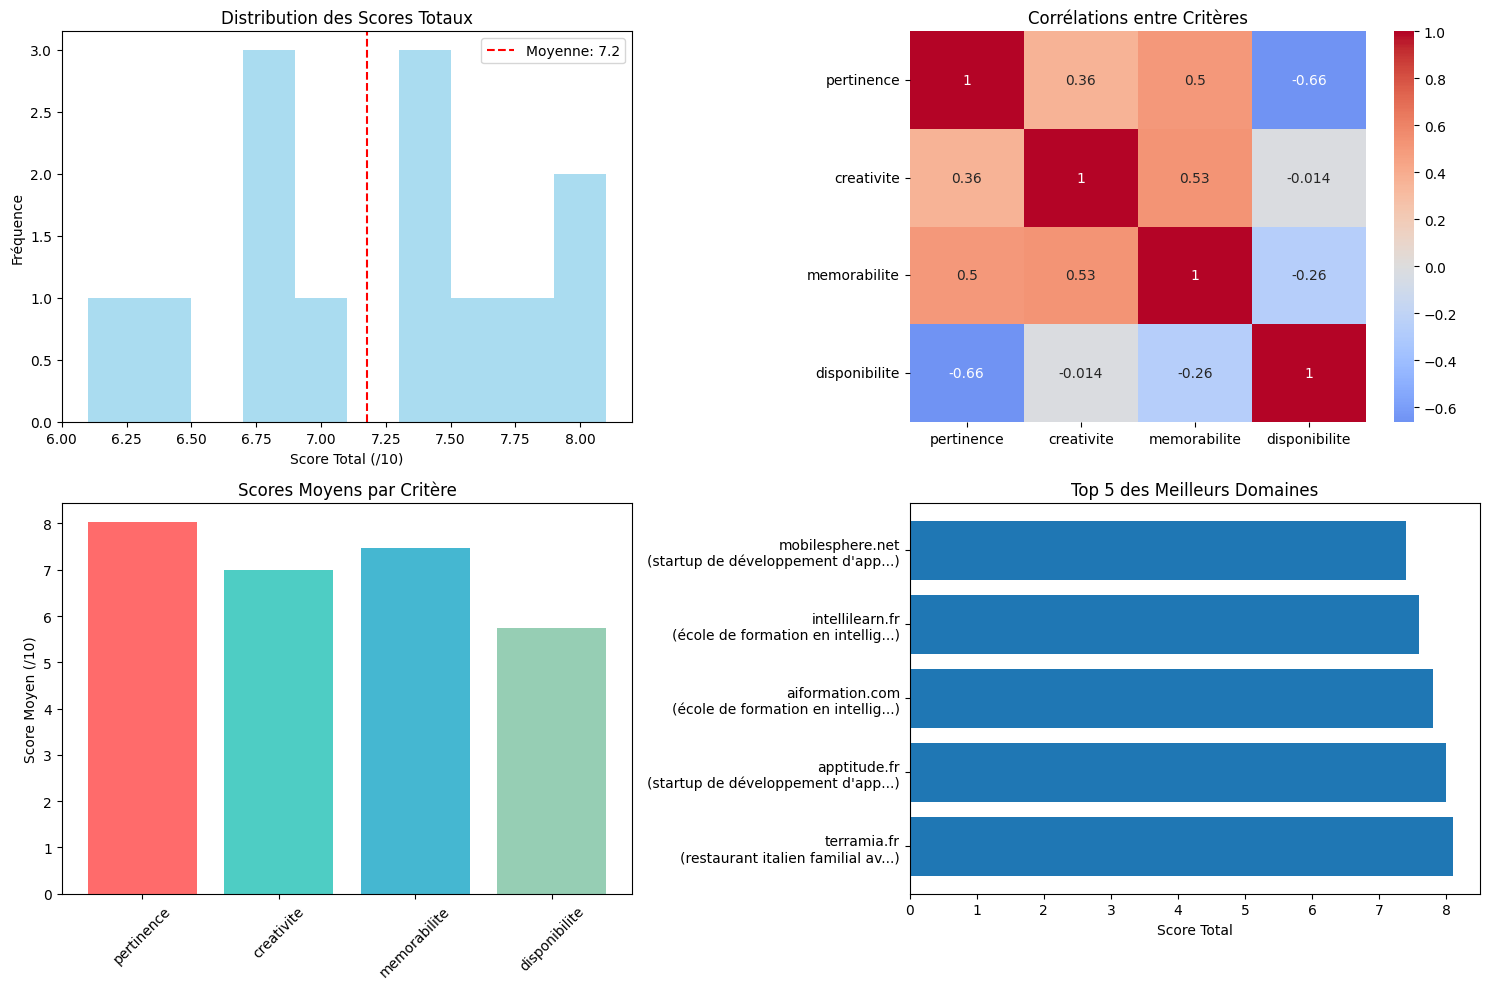

INFO:src.utils:Donn√©es sauvegard√©es dans ../data/evaluations/resultats_baseline.json



Analyse des performances baseline:
   - Score total moyen: 7.18/10
   - Crit√®re le plus faible: disponibilite (5.73/10)
   - Crit√®re le plus fort: pertinence (8.04/10)

R√©sultats baseline sauvegard√©s dans data/evaluations/resultats_baseline.json


In [8]:
# Analyse des r√©sultats d'√©valuation baseline
if evaluations_baseline:
    # Extraire tous les scores
    tous_scores = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores.append({
                "domaine": eval_domaine["domaine"],
                "description": eval_result["description"][:30] + "...",
                "score_total": eval_domaine["score_total"],
                "pertinence": eval_domaine["pertinence"],
                "creativite": eval_domaine["creativite"],
                "memorabilite": eval_domaine["memorabilite"],
                "disponibilite": eval_domaine["disponibilite_estimee"]
            })
    
    # Cr√©er un DataFrame pour l'analyse
    df_scores = pd.DataFrame(tous_scores)
    
    print("Statistiques des √©valuations baseline:")
    print(df_scores[['score_total', 'pertinence', 'creativite', 'memorabilite', 'disponibilite']].describe())
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des scores totaux
    axes[0,0].hist(df_scores['score_total'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution des Scores Totaux')
    axes[0,0].set_xlabel('Score Total (/10)')
    axes[0,0].set_ylabel('Fr√©quence')
    axes[0,0].axvline(df_scores['score_total'].mean(), color='red', linestyle='--', 
                     label=f'Moyenne: {df_scores["score_total"].mean():.1f}')
    axes[0,0].legend()
    
    # Corr√©lation entre crit√®res
    correlation_matrix = df_scores[['pertinence', 'creativite', 'memorabilite', 'disponibilite']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Corr√©lations entre Crit√®res')
    
    # Scores par crit√®re
    criteres = ['pertinence', 'creativite', 'memorabilite', 'disponibilite']
    moyennes_criteres = [df_scores[critere].mean() for critere in criteres]
    axes[1,0].bar(criteres, moyennes_criteres, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1,0].set_title('Scores Moyens par Crit√®re')
    axes[1,0].set_ylabel('Score Moyen (/10)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Top 5 des meilleurs domaines
    top_domaines = df_scores.nlargest(5, 'score_total')
    axes[1,1].barh(range(len(top_domaines)), top_domaines['score_total'])
    axes[1,1].set_yticks(range(len(top_domaines)))
    axes[1,1].set_yticklabels([f"{row['domaine']}\n({row['description']})" for _, row in top_domaines.iterrows()])
    axes[1,1].set_title('Top 5 des Meilleurs Domaines')
    axes[1,1].set_xlabel('Score Total')
    
    plt.tight_layout()
    plt.show()
    
    # Identifier les points faibles
    print("\nAnalyse des performances baseline:")
    print(f"   - Score total moyen: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Crit√®re le plus faible: {criteres[np.argmin(moyennes_criteres)]} ({min(moyennes_criteres):.2f}/10)")
    print(f"   - Crit√®re le plus fort: {criteres[np.argmax(moyennes_criteres)]} ({max(moyennes_criteres):.2f}/10)")
    
    # Sauvegarder les r√©sultats baseline
    sauvegarder_json({
        "timestamp": generer_timestamp(),
        "version": "baseline",
        "evaluations": evaluations_baseline,
        "statistiques": {
            "score_moyen": float(df_scores['score_total'].mean()),
            "score_median": float(df_scores['score_total'].median()),
            "nombre_evaluations": len(df_scores)
        }
    }, "../data/evaluations/resultats_baseline.json")
    
    print("\nR√©sultats baseline sauvegard√©s dans data/evaluations/resultats_baseline.json")
    
else:
    print("Aucune √©valuation baseline disponible pour l'analyse")

## 5. D√©couverte et Analyse des Cas Limites

Identification syst√©matique des modes d'√©chec du mod√®le et classification des probl√®mes.

In [9]:
# Charger les cas limites du dataset
cas_limites = dataset_complet['cas_limites']

print(f"Analyse des cas limites ({len(cas_limites)} cas)...\n")

# Grouper par cat√©gorie
categories_cas_limites = {}
for cas in cas_limites:
    categorie = cas['categorie']
    if categorie not in categories_cas_limites:
        categories_cas_limites[categorie] = []
    categories_cas_limites[categorie].append(cas)

print("Cat√©gories de cas limites identifi√©es:")
for categorie, liste_cas in categories_cas_limites.items():
    print(f"   - {categorie.replace('_', ' ').title()}: {len(liste_cas)} cas")
    for cas in liste_cas[:2]:  # Afficher 2 exemples maximum
        print(f"     ‚Üí \"{cas['description'][:60]}...\"")

Analyse des cas limites (14 cas)...

Cat√©gories de cas limites identifi√©es:
   - Description Courte: 2 cas
     ‚Üí "caf√©..."
     ‚Üí "tech..."
   - Description Longue: 1 cas
     ‚Üí "Une entreprise de d√©veloppement de logiciels sp√©cialis√©e dan..."
   - Description Vague: 2 cas
     ‚Üí "quelque chose de bien..."
     ‚Üí "entreprise moderne..."
   - Caracteres Speciaux: 2 cas
     ‚Üí "caf√© & restaurant fran√ßais..."
     ‚Üí "entreprise high-tech √† 100%..."
   - Langue Etrangere: 3 cas
     ‚Üí "restaurant italiano molto buono..."
     ‚Üí "English consulting firm..."
   - Concept Abstrait: 2 cas
     ‚Üí "plateforme de bonheur digital..."
     ‚Üí "solutions de bien-√™tre √©nerg√©tique..."
   - Niche Specifique: 2 cas
     ‚Üí "r√©paration de violons anciens..."
     ‚Üí "√©levage de papillons exotiques..."


In [10]:
# Tester le g√©n√©rateur sur les cas limites
print("Test du g√©n√©rateur sur les cas limites...\n")

resultats_cas_limites = {}
echecs_par_categorie = {}

for categorie, liste_cas in categories_cas_limites.items():
    print(f"Test de la cat√©gorie: {categorie}")
    resultats_categorie = []
    echecs_categorie = 0
    
    for i, cas in enumerate(liste_cas):
        description = cas['description']
        print(f"   Test {i+1}/{len(liste_cas)}: {description}")
        
        try:
            resultat = generateur.generer_suggestions(
                description_business=description,
                nombre_suggestions=3,
                style="professionnel",
                avec_filtrage=True
            )
            
            if resultat["status"] == "success":
                nb_suggestions = len(resultat["suggestions"])
                print(f"     {nb_suggestions} suggestions g√©n√©r√©es")
                
                # √âvaluer la qualit√© si des suggestions ont √©t√© g√©n√©r√©es
                if nb_suggestions > 0:
                    domaines = [s["domaine"] for s in resultat["suggestions"]]
                    try:
                        evaluation = evaluateur.evaluer_suggestions(description, domaines)
                        if evaluation["status"] == "success":
                            score_moyen = np.mean([e["score_total"] for e in evaluation["evaluations"]])
                            print(f"     Score moyen: {score_moyen:.1f}/10")
                        else:
                            score_moyen = None
                    except:
                        score_moyen = None
                else:
                    score_moyen = 0
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": score_moyen,
                    "nb_suggestions": nb_suggestions
                })
                
            elif resultat["status"] == "blocked":
                print(f"     Bloqu√©: {resultat.get('message', 'Contenu inappropri√©')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "filtrage_securite"
                })
            else:
                print(f"     √âchec: {resultat.get('message', 'Erreur inconnue')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "generation_failed"
                })
                
        except Exception as e:
            print(f"     Erreur: {e}")
            echecs_categorie += 1
    
    resultats_cas_limites[categorie] = resultats_categorie
    echecs_par_categorie[categorie] = echecs_categorie
    
    taux_reussite = (len(liste_cas) - echecs_categorie) / len(liste_cas) * 100
    print(f"   Taux de r√©ussite: {taux_reussite:.1f}% ({len(liste_cas) - echecs_categorie}/{len(liste_cas)})\n")

print("Analyse des cas limites termin√©e")

INFO:src.utils:G√©n√©ration de 3 | suggestions pour: caf√©...


Test du g√©n√©rateur sur les cas limites...

Test de la cat√©gorie: description_courte
   Test 1/2: caf√©


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es


     2 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.25/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: tech...


     Score moyen: 7.2/10
   Test 2/2: tech


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es


     2 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.80/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: Une entreprise de d√©veloppement de logiciels sp√©ci...
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: quelque chose de bien...


     Score moyen: 6.8/10
   Taux de r√©ussite: 100.0% (2/2)

Test de la cat√©gorie: description_longue
   Test 1/1: Une entreprise de d√©veloppement de logiciels sp√©cialis√©e dans les solutions d'intelligence artificielle et d'apprentissage automatique pour les grandes entreprises du secteur financier avec une expertise particuli√®re en algorithmes de d√©tection de fraude et syst√®mes de recommandation personnalis√©s utilisant des technologies de pointe comme TensorFlow et PyTorch
     Bloqu√©: Description contient du contenu inappropri√©
   Taux de r√©ussite: 0.0% (0/1)

Test de la cat√©gorie: description_vague
   Test 1/2: quelque chose de bien


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 1 suggestions cr√©√©es


     1 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.10/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: entreprise moderne...


     Score moyen: 6.1/10
   Test 2/2: entreprise moderne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.07/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: caf√© & restaurant fran√ßais...


     Score moyen: 7.1/10
   Taux de r√©ussite: 100.0% (2/2)

Test de la cat√©gorie: caracteres_speciaux
   Test 1/2: caf√© & restaurant fran√ßais


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.53/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: entreprise high-tech √† 100%...


     Score moyen: 6.5/10
   Test 2/2: entreprise high-tech √† 100%


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.27/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: restaurant italiano molto buono...


     Score moyen: 6.3/10
   Taux de r√©ussite: 100.0% (2/2)

Test de la cat√©gorie: langue_etrangere
   Test 1/3: restaurant italiano molto buono


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.90/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: English consulting firm...


     Score moyen: 6.9/10
   Test 2/3: English consulting firm


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es


     2 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.20/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: restaurant Bilima...


     Score moyen: 7.2/10
   Test 3/3: restaurant Bilima


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.73/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: plateforme de bonheur digital...


     Score moyen: 6.7/10
   Taux de r√©ussite: 100.0% (3/3)

Test de la cat√©gorie: concept_abstrait
   Test 1/2: plateforme de bonheur digital


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es


     2 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.90/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: solutions de bien-√™tre √©nerg√©tique...


     Score moyen: 6.9/10
   Test 2/2: solutions de bien-√™tre √©nerg√©tique


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 2 suggestions cr√©√©es


     2 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.25/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: r√©paration de violons anciens...


     Score moyen: 7.2/10
   Taux de r√©ussite: 100.0% (2/2)

Test de la cat√©gorie: niche_specifique
   Test 1/2: r√©paration de violons anciens


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es


     3 suggestions g√©n√©r√©es


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.77/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: √©levage de papillons exotiques...


     Score moyen: 6.8/10
   Test 2/2: √©levage de papillons exotiques
     Bloqu√©: Description contient du contenu inappropri√©
   Taux de r√©ussite: 50.0% (1/2)

Analyse des cas limites termin√©e


Analyse d√©taill√©e des performances sur les cas limites

Statistiques par cat√©gorie de cas limites:
             categorie  nb_total  taux_reussite  score_moyen  \
0   description_courte         2          100.0         7.02   
1   description_longue         1            0.0         0.00   
2    description_vague         2          100.0         6.58   
3  caracteres_speciaux         2          100.0         6.40   
4     langue_etrangere         3          100.0         6.94   
5     concept_abstrait         2          100.0         7.08   
6     niche_specifique         2           50.0         6.77   

   suggestions_moyennes  
0                  2.00  
1                  0.00  
2                  2.00  
3                  3.00  
4                  2.67  
5                  2.00  
6                  1.50  


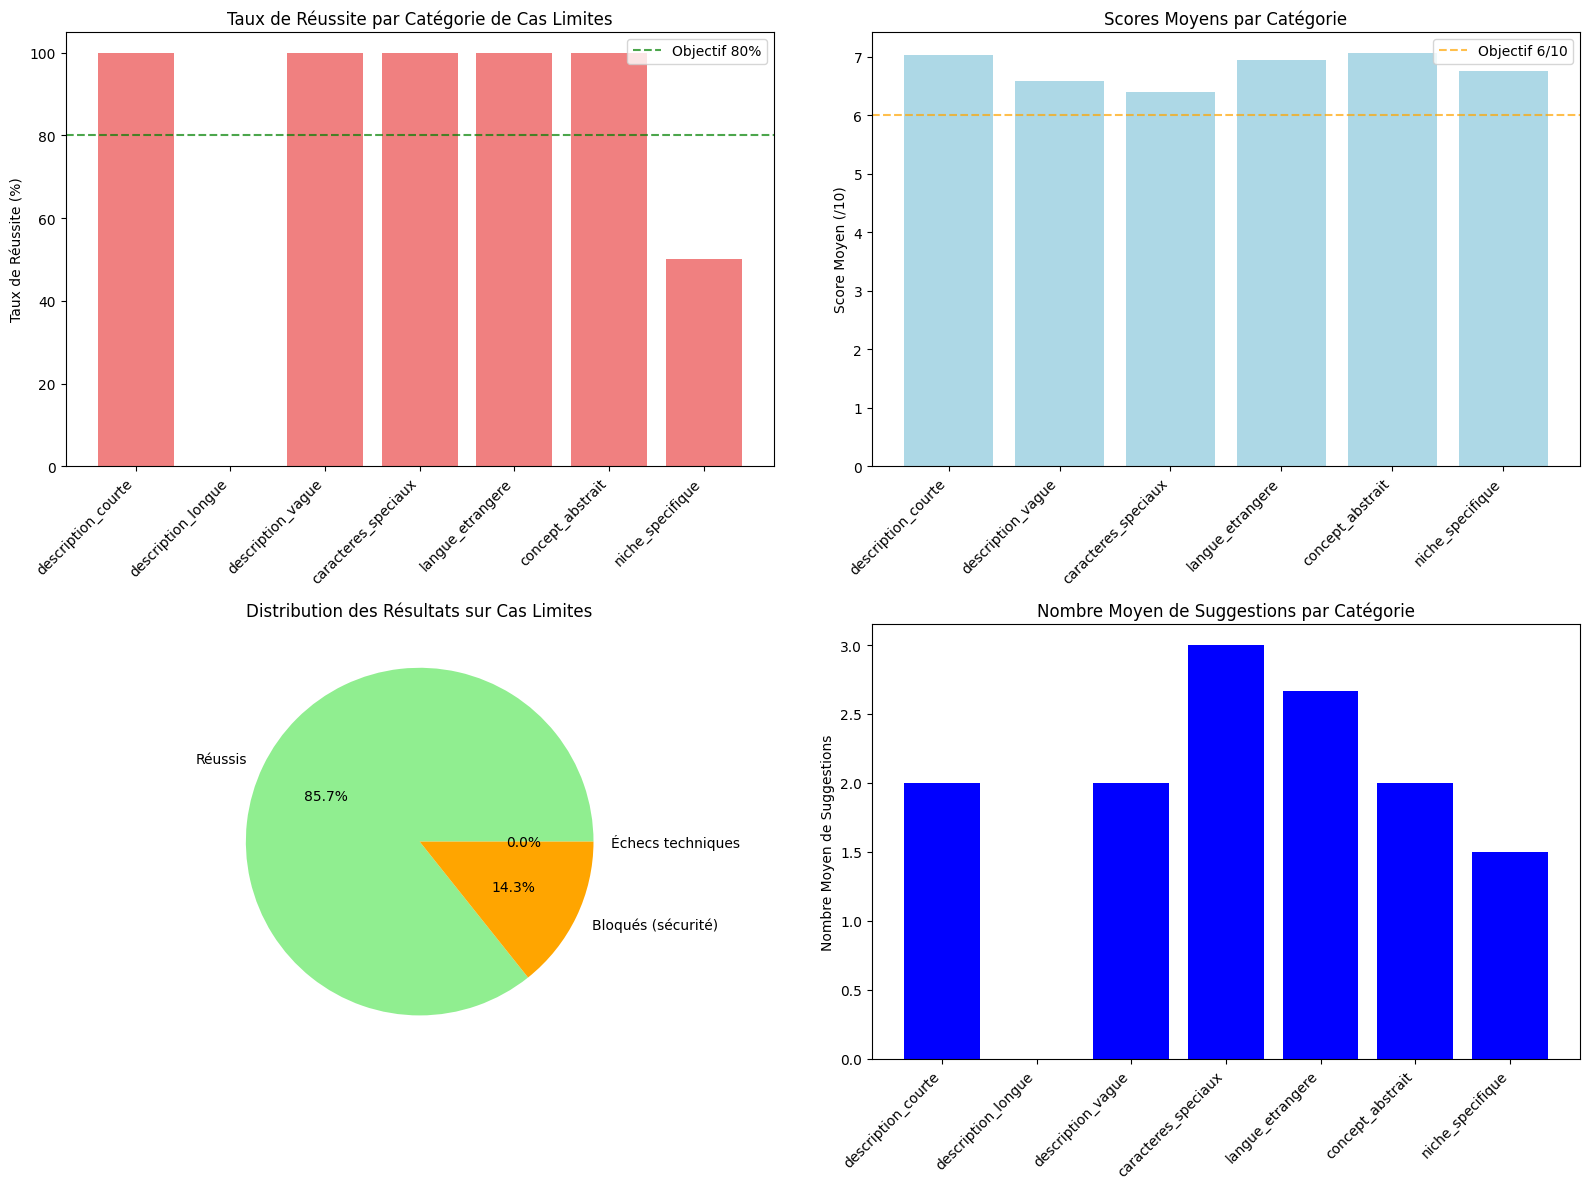

INFO:src.utils:Donn√©es sauvegard√©es dans ../data/evaluations/analyse_cas_limites_baseline.json



Cat√©gories probl√©matiques (< 50% de r√©ussite):
   - description_longue: 0.0% de r√©ussite

Cat√©gories excellentes (‚â• 80% de r√©ussite):
   - description_courte: 100.0% de r√©ussite
   - description_vague: 100.0% de r√©ussite
   - caracteres_speciaux: 100.0% de r√©ussite
   - langue_etrangere: 100.0% de r√©ussite
   - concept_abstrait: 100.0% de r√©ussite

Analyse des cas limites sauvegard√©e


In [11]:
# Analyse d√©taill√©e des r√©sultats des cas limites
print("Analyse d√©taill√©e des performances sur les cas limites\n")

# Calculer les statistiques par cat√©gorie
stats_categories = []

for categorie, resultats in resultats_cas_limites.items():
    nb_total = len(resultats)
    nb_reussis = len([r for r in resultats if r['nb_suggestions'] > 0])
    nb_bloques = len([r for r in resultats if r.get('type_echec') == 'filtrage_securite'])
    nb_echecs_tech = len([r for r in resultats if r.get('type_echec') == 'generation_failed'])
    
    scores_valides = [r['score_moyen'] for r in resultats if r['score_moyen'] is not None]
    score_moyen_categorie = np.mean(scores_valides) if scores_valides else 0
    
    suggestions_moyennes = np.mean([r['nb_suggestions'] for r in resultats])
    
    stats_categories.append({
        'categorie': categorie,
        'nb_total': nb_total,
        'nb_reussis': nb_reussis,
        'nb_bloques': nb_bloques,
        'nb_echecs_tech': nb_echecs_tech,
        'taux_reussite': (nb_reussis / nb_total) * 100,
        'score_moyen': score_moyen_categorie,
        'suggestions_moyennes': suggestions_moyennes
    })

# Cr√©er un DataFrame pour l'analyse
df_stats = pd.DataFrame(stats_categories)

print("Statistiques par cat√©gorie de cas limites:")
print(df_stats[['categorie', 'nb_total', 'taux_reussite', 'score_moyen', 'suggestions_moyennes']].round(2))

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Taux de r√©ussite par cat√©gorie
categories = df_stats['categorie']
taux_reussite = df_stats['taux_reussite']

axes[0,0].bar(range(len(categories)), taux_reussite, color='lightcoral')
axes[0,0].set_title('Taux de R√©ussite par Cat√©gorie de Cas Limites')
axes[0,0].set_ylabel('Taux de R√©ussite (%)')
axes[0,0].set_xticks(range(len(categories)))
axes[0,0].set_xticklabels(categories, rotation=45, ha='right')
axes[0,0].axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Objectif 80%')
axes[0,0].legend()

# Scores moyens par cat√©gorie
scores_valides = df_stats[df_stats['score_moyen'] > 0]
if not scores_valides.empty:
    axes[0,1].bar(range(len(scores_valides)), scores_valides['score_moyen'], color='lightblue')
    axes[0,1].set_title('Scores Moyens par Cat√©gorie')
    axes[0,1].set_ylabel('Score Moyen (/10)')
    axes[0,1].set_xticks(range(len(scores_valides)))
    axes[0,1].set_xticklabels(scores_valides['categorie'], rotation=45, ha='right')
    axes[0,1].axhline(y=6, color='orange', linestyle='--', alpha=0.7, label='Objectif 6/10')
    axes[0,1].legend()

# Distribution des types d'√©checs
echecs_data = {
    'R√©ussis': df_stats['nb_reussis'].sum(),
    'Bloqu√©s (s√©curit√©)': df_stats['nb_bloques'].sum(),
    '√âchecs techniques': df_stats['nb_echecs_tech'].sum()
}

axes[1,0].pie(echecs_data.values(), labels=echecs_data.keys(), autopct='%1.1f%%',
              colors=['lightgreen', 'orange', 'lightcoral'])
axes[1,0].set_title('Distribution des R√©sultats sur Cas Limites')

# Nombre moyen de suggestions par cat√©gorie
axes[1,1].bar(range(len(categories)), df_stats['suggestions_moyennes'], color='blue')
axes[1,1].set_title('Nombre Moyen de Suggestions par Cat√©gorie')
axes[1,1].set_ylabel('Nombre Moyen de Suggestions')
axes[1,1].set_xticks(range(len(categories)))
axes[1,1].set_xticklabels(categories, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Identifier les cat√©gories probl√©matiques
categories_problematiques = df_stats[df_stats['taux_reussite'] < 50]
categories_excellentes = df_stats[df_stats['taux_reussite'] >= 80]

print(f"\nCat√©gories probl√©matiques (< 50% de r√©ussite):")
if not categories_problematiques.empty:
    for _, row in categories_problematiques.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de r√©ussite")
else:
    print("   Aucune cat√©gorie sous les 50%")

print(f"\nCat√©gories excellentes (‚â• 80% de r√©ussite):")
if not categories_excellentes.empty:
    for _, row in categories_excellentes.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de r√©ussite")
else:
    print("   Aucune cat√©gorie au-dessus de 80%")

# Sauvegarder l'analyse des cas limites
sauvegarder_json({
    "timestamp": generer_timestamp(),
    "version": "baseline",
    "resultats_cas_limites": resultats_cas_limites,
    "statistiques_categories": stats_categories,
    "analyse": {
        "taux_reussite_global": df_stats['taux_reussite'].mean(),
        "score_moyen_global": df_stats['score_moyen'].mean(),
        "categories_problematiques": categories_problematiques['categorie'].tolist(),
        "categories_excellentes": categories_excellentes['categorie'].tolist()
    }
}, "../data/evaluations/analyse_cas_limites_baseline.json")

print("\nAnalyse des cas limites sauvegard√©e")

## 6. Test et Validation des Garde-fous de S√©curit√©

√âvaluation de l'efficacit√© du syst√®me de filtrage de contenu.

In [12]:
# Initialiser et tester les garde-fous

garde_fous = GardeFousSecurite()
testeur_securite = TesteurSecurite(garde_fous)

print("Test des garde-fous de s√©curit√©...\n")

# Ex√©cuter les tests de s√©curit√©
resultats_tests_securite = testeur_securite.tester_cas_limites_securite()

# Afficher les r√©sultats
stats = resultats_tests_securite['statistiques']
print(f"R√©sultats des tests de s√©curit√©:")
print(f"   - Pr√©cision pour cas n√©gatifs: {stats['precision_negative']:.1%}")
print(f"   - Pr√©cision pour cas positifs: {stats['precision_positive']:.1%}")
print(f"   - Pr√©cision globale: {stats['precision_globale']:.1%}")

# Analyser les cas probl√©matiques
cas_negatifs_rates = [cas for cas in resultats_tests_securite['cas_negatifs'] if not cas['correctement_rejete']]
cas_positifs_rates = [cas for cas in resultats_tests_securite['cas_positifs'] if not cas['correctement_accepte']]

if cas_negatifs_rates:
    print(f"\nCas n√©gatifs non d√©tect√©s ({len(cas_negatifs_rates)}):")
    for cas in cas_negatifs_rates:
        print(f"   - \"{cas['description']}\" (score: {cas['score_risque']:.2f})")

if cas_positifs_rates:
    print(f"\nCas positifs rejet√©s √† tort ({len(cas_positifs_rates)}):")
    for cas in cas_positifs_rates:
        print(f"   - \"{cas['description']}\" (score: {cas['score_risque']:.2f})")

# Tester avec des domaines g√©n√©r√©s
print(f"\nTest des garde-fous sur domaines g√©n√©r√©s...")

domaines_test = ["example.com", "test-site.fr", "inappropriate-content.com", "normal-business.org"]
validations_domaines = garde_fous.valider_liste_domaines(domaines_test)

for validation in validations_domaines:
    status = "‚úÖ" if validation['est_acceptable'] else "‚ùå"
    print(f"   {status} {validation['domaine']} (qualit√©: {validation['score_qualite']:.2f})")
    if validation['raisons_rejet']:
        for raison in validation['raisons_rejet']:
            print(f"     {raison}")

Test des garde-fous de s√©curit√©...

R√©sultats des tests de s√©curit√©:
   - Pr√©cision pour cas n√©gatifs: 80.0%
   - Pr√©cision pour cas positifs: 100.0%
   - Pr√©cision globale: 90.0%

Cas n√©gatifs non d√©tect√©s (1):
   - "plateforme de t√©l√©chargement ill√©gal" (score: 0.00)

Test des garde-fous sur domaines g√©n√©r√©s...
   ‚ùå example.com (qualit√©: 0.00)
     Terme inappropri√©: x
   ‚úÖ test-site.fr (qualit√©: 1.00)
   ‚úÖ inappropriate-content.com (qualit√©: 1.00)
   ‚úÖ normal-business.org (qualit√©: 1.00)


## 7. Am√©lioration It√©rative du Mod√®le

Bas√© sur l'analyse des cas limites et des √©valuations, nous allons impl√©menter des am√©liorations.

In [13]:
# Analyser les r√©sultats pour identifier les axes d'am√©lioration
print("Identification des axes d'am√©lioration...\n")

# Synth√®se des performances baseline
if evaluations_baseline:
    tous_scores_baseline = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores_baseline.append(eval_domaine)
    
    score_moyen_baseline = np.mean([s["score_total"] for s in tous_scores_baseline])
    pertinence_moyenne = np.mean([s["pertinence"] for s in tous_scores_baseline])
    creativite_moyenne = np.mean([s["creativite"] for s in tous_scores_baseline])
    memorabilite_moyenne = np.mean([s["memorabilite"] for s in tous_scores_baseline])
    
    print(f"Performance baseline:")
    print(f"   - Score global: {score_moyen_baseline:.2f}/10")
    print(f"   - Pertinence: {pertinence_moyenne:.2f}/10")
    print(f"   - Cr√©ativit√©: {creativite_moyenne:.2f}/10")
    print(f"   - M√©morabilit√©: {memorabilite_moyenne:.2f}/10")

# Analyser les cas limites les plus probl√©matiques
if 'df_stats' in locals():
    categories_faibles = df_stats[df_stats['taux_reussite'] < 70]
    print(f"\nCat√©gories n√©cessitant une am√©lioration:")
    for _, row in categories_faibles.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de r√©ussite")

# D√©finir les strat√©gies d'am√©lioration
strategies_amelioration = {
    "prompt_engineering": {
        "description": "Am√©lioration des prompts avec des exemples et contraintes sp√©cifiques",
        "actions": [
            "Ajouter des exemples de bons noms de domaine",
            "Sp√©cifier des contraintes de longueur",
            "Inclure des instructions pour les cas limites"
        ]
    },
    "parametres_generation": {
        "description": "Optimisation des param√®tres de g√©n√©ration",
        "actions": [
            "Ajuster la temp√©rature (cr√©ativit√© vs coh√©rence)",
            "Modifier top_p pour la diversit√©",
            "Augmenter le nombre de tokens g√©n√©r√©s"
        ]
    },
    "post_processing": {
        "description": "Am√©lioration du post-traitement",
        "actions": [
            "Meilleur nettoyage des suggestions",
            "Validation renforc√©e des domaines",
            "Scoring de confiance am√©lior√©"
        ]
    }
}

print(f"\nStrat√©gies d'am√©lioration identifi√©es:")
for nom, strategie in strategies_amelioration.items():
    print(f"\n   {nom.upper().replace('_', ' ')}:")
    print(f"   {strategie['description']}")
    for action in strategie['actions']:
        print(f"     . {action}")

Identification des axes d'am√©lioration...

Performance baseline:
   - Score global: 7.18/10
   - Pertinence: 8.04/10
   - Cr√©ativit√©: 7.00/10
   - M√©morabilit√©: 7.46/10

Cat√©gories n√©cessitant une am√©lioration:
   - description_longue: 0.0% de r√©ussite
   - niche_specifique: 50.0% de r√©ussite

Strat√©gies d'am√©lioration identifi√©es:

   PROMPT ENGINEERING:
   Am√©lioration des prompts avec des exemples et contraintes sp√©cifiques
     . Ajouter des exemples de bons noms de domaine
     . Sp√©cifier des contraintes de longueur
     . Inclure des instructions pour les cas limites

   PARAMETRES GENERATION:
   Optimisation des param√®tres de g√©n√©ration
     . Ajuster la temp√©rature (cr√©ativit√© vs coh√©rence)
     . Modifier top_p pour la diversit√©
     . Augmenter le nombre de tokens g√©n√©r√©s

   POST PROCESSING:
   Am√©lioration du post-traitement
     . Meilleur nettoyage des suggestions
     . Validation renforc√©e des domaines
     . Scoring de confiance am√©lior√©

In [14]:
# Impl√©mentation de la version am√©lior√©e - Prompt Engineering

class GenerateurAmeliore(GenerateurNomsDomaine):
    """Version am√©lior√©e du g√©n√©rateur avec prompt engineering avanc√©."""
    
    def __init__(self, modele: str = None, garde_fous: bool = True):
        # H√©riter de la classe parent
        super().__init__(modele, garde_fous)
        
        # Nouveau template de prompt am√©lior√©
        self.template_prompt_ameliore = PromptTemplate(
            input_variables=["description_business", "nombre_suggestions", "style"],
            template="""Tu es un expert en cr√©ation de noms de domaine avec 10 ans d'exp√©rience.

                DESCRIPTION BUSINESS: {description_business}

                INSTRUCTIONS D√âTAILL√âES:
                1. G√©n√®re exactement {nombre_suggestions} suggestions de noms de domaine
                2. Style demand√©: {style}
                3. Chaque nom doit √™tre:
                - Entre 6 et 15 caract√®res (sans l'extension)
                - Facile √† √©peler et m√©moriser
                - Pertinent pour l'activit√© d√©crite
                - √âviter les tirets multiples (-- interdits)
                - Professionnels et appropri√©s

                EXEMPLES DE BONS NOMS:
                - Restaurant italien : "gustorama.com", "bellavita.fr", "pastafino.com"
                - Tech startup : "innovatech.com", "nexuslab.io", "bytecraft.net"
                - Cabinet conseil : "expertum.fr", "strategie-plus.com", "conseilo.net"

                EXTENSIONS PR√âF√âR√âES: .com, .fr, .org, .net (dans cet ordre)

                GESTION DES CAS PARTICULIERS:
                - Description courte : √ätre cr√©atif avec synonymes et d√©riv√©s
                - Description longue : Extraire les concepts cl√©s principaux
                - Description vague : Proposer des noms g√©n√©riques mais professionnels
                - Langues √©trang√®res : Adapter en fran√ßais ou anglais selon le contexte

                FORMAT DE R√âPONSE (JSON strict):
                {{
                    "suggestions": [
                        {{"domaine": "exemple1.com", "explication": "Combine 'exemple' et modernit√©"}},
                        {{"domaine": "exemple2.fr", "explication": "Jeu sur les mots avec impact"}}
                    ]
                }}

                R√©ponds UNIQUEMENT avec le JSON, aucun autre texte."""
            )
        
        # Utiliser la nouvelle syntaxe RunnableSequence au lieu de LLMChain
        self.chain_ameliore = self.template_prompt_ameliore | self.llm
        
        # Param√®tres am√©lior√©s
        self.llm.temperature = 0.9
        self.llm.top_p = 0.95
        self.llm.num_predict = 2000
    
    def generer_suggestions_ameliorees(self, 
                                     description_business: str, 
                                     nombre_suggestions: int = 5,
                                     style: str = "professionnel",
                                     avec_filtrage: bool = True) -> Dict[str, any]:
        """Version am√©lior√©e de la g√©n√©ration avec prompt engineering."""
        
        logger.info(f"G√©n√©ration am√©lior√©e pour: {description_business[:50]}...")
        
        # V√©rifications de s√©curit√© identiques
        if avec_filtrage and self.garde_fous:
            analyse_description = self.garde_fous.analyser_description(description_business)
            if not analyse_description['est_acceptable']:
                return {
                    "suggestions": [],
                    "status": "blocked",
                    "message": "Description contient du contenu inappropri√©",
                    "details_filtrage": analyse_description
                }
        
        # Pr√©paration sp√©ciale pour les cas limites
        description_preprocessed = self._preprocess_description(description_business)
        
        try:
            debut = time.time()
            
            # Utiliser la nouvelle syntaxe RunnableSequence
            reponse = self.chain_ameliore.invoke({
                "description_business": description_preprocessed,
                "nombre_suggestions": nombre_suggestions,
                "style": self.styles_disponibles.get(style, "professionnel")
            })
            
            duree_generation = time.time() - debut
            
            # Parser et valider avec post-processing am√©lior√©
            suggestions_brutes = self._parser_reponse_llm(reponse)
            suggestions_validees = self._valider_suggestions_ameliorees(suggestions_brutes, avec_filtrage)
            suggestions_avec_scores = self._calculer_scores_confiance_ameliores(suggestions_validees, description_business)
            
            return {
                "suggestions": suggestions_avec_scores,
                "status": "success",
                "version": "amelioree_v1",
                "metadata": {
                    "description_originale": description_business,
                    "description_preprocessed": description_preprocessed,
                    "style_utilise": style,
                    "nombre_demande": nombre_suggestions,
                    "nombre_genere": len(suggestions_avec_scores),
                    "duree_generation_sec": round(duree_generation, 2),
                    "modele_utilise": self.model + "_ameliore",
                    "filtrage_active": avec_filtrage
                }
            }
            
        except Exception as e:
            logger.error(f"Erreur lors de la g√©n√©ration am√©lior√©e: {e}")
            return {
                "suggestions": [],
                "status": "error",
                "message": f"Erreur lors de la g√©n√©ration: {str(e)}"
            }
    
    def _preprocess_description(self, description: str) -> str:
        """Pr√©processing sp√©cialis√© pour les cas limites."""
        # Gestion des descriptions tr√®s courtes
        if len(description.split()) <= 2:
            return f"Entreprise ou service dans le domaine: {description}. Activit√© commerciale professionnelle."
        
        # Gestion des descriptions tr√®s longues
        if len(description.split()) > 30:
            mots = description.split()[:20]  # Garder les 20 premiers mots
            return ' '.join(mots) + "..."
        
        return description
    
    def _valider_suggestions_ameliorees(self, suggestions: List[Dict[str, str]], avec_filtrage: bool) -> List[Dict[str, str]]:
        """Validation am√©lior√©e avec crit√®res plus stricts."""
        suggestions_validees = []
        
        for suggestion in suggestions:
            if not isinstance(suggestion, dict) or "domaine" not in suggestion:
                continue
            
            domaine = nettoyer_nom_domaine(suggestion["domaine"])
            nom_sans_extension = domaine.split(".")[0] if "." in domaine else domaine
            
            # Crit√®res de validation am√©lior√©s
            if len(nom_sans_extension) < 3 or len(nom_sans_extension) > 20:
                continue
            
            if not "." in domaine:
                continue
            
            # √âviter les caract√®res r√©p√©titifs
            if any(char * 3 in nom_sans_extension for char in "abcdefghijklmnopqrstuvwxyz"):
                continue
            
            # √âviter les tirets multiples
            if "--" in domaine:
                continue
            
            # Filtrage de s√©curit√©
            if avec_filtrage and self.garde_fous:
                validation = self.garde_fous.filtrer_nom_domaine(domaine)
                if not validation["est_acceptable"]:
                    continue
            
            suggestions_validees.append({
                "domaine": domaine,
                "explication": suggestion.get("explication", "")
            })
        
        return suggestions_validees
    
    def _calculer_scores_confiance_ameliores(self, suggestions: List[Dict[str, str]], description: str) -> List[Dict[str, any]]:
        """Calcul de scores de confiance am√©lior√©s."""
        mots_cles_description = set(description.lower().split())
        suggestions_avec_scores = []
        
        for suggestion in suggestions:
            domaine = suggestion["domaine"]
            nom_sans_extension = domaine.split(".")[0]
            extension = domaine.split(".")[1] if "." in domaine else "com"
            
            # Score de base plus g√©n√©reux
            score = 0.6
            
            # Bonus pour longueur optimale (6-12 caract√®res)
            longueur = len(nom_sans_extension)
            if 6 <= longueur <= 12:
                score += 0.15
            elif 4 <= longueur <= 15:
                score += 0.1
            
            # Bonus pour facilit√© de m√©morisation
            if nom_sans_extension.islower() and nom_sans_extension.isalpha():
                score += 0.1
            
            # Bonus pour extension premium
            bonus_extension = {".com": 0.15, ".fr": 0.12, ".org": 0.08, ".net": 0.05}
            score += bonus_extension.get(f".{extension}", 0)
            
            # Bonus pour pertinence (recherche de correspondances)
            mots_domaine = set([nom_sans_extension] + nom_sans_extension.split("-"))
            correspondances = 0
            for mot_desc in mots_cles_description:
                for mot_dom in mots_domaine:
                    if mot_desc.lower() in mot_dom.lower() or mot_dom.lower() in mot_desc.lower():
                        correspondances += 1
            
            if correspondances > 0:
                score += min(0.15, correspondances * 0.05)
            
            # Normaliser le score
            score = max(0.1, min(1.0, score))
            
            suggestions_avec_scores.append({
                "domaine": domaine,
                "confidence": round(score, 2),
                "explication": suggestion["explication"]
            })
        
        # Trier par score d√©croissant
        suggestions_avec_scores.sort(key=lambda x: x["confidence"], reverse=True)
        
        return suggestions_avec_scores

# Initialiser la version am√©lior√©e
print("Initialisation du g√©n√©rateur am√©lior√©...")
try:
    generateur_ameliore = GenerateurAmeliore(modele="llama3.1", garde_fous=True)
    print("G√©n√©rateur am√©lior√© initialis√© avec succ√®s")
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")

INFO:src.utils:Mod√®le llama3.1 initialis√© avec succ√®s


Initialisation du g√©n√©rateur am√©lior√©...
G√©n√©rateur am√©lior√© initialis√© avec succ√®s


In [15]:
# Test et comparaison des versions baseline vs am√©lior√©e
print("Comparaison baseline vs version am√©lior√©e...\n")

# Descriptions de test pour la comparaison
descriptions_comparaison = [
    "caf√©",  # Cas limite : description courte
    "restaurant italien moderne avec terrasse",  # Cas normal
    "startup d√©veloppement intelligence artificielle machine learning solutions entreprises fintech",  # Cas limite : description longue
    "service bien-√™tre digital",  # Cas limite : concept abstrait
    "boutique v√™tements bio √©thiques"  # Cas normal
]

resultats_comparaison = []

for i, description in enumerate(descriptions_comparaison, 1):
    print(f"Test {i}/5: {description}")
    print(f"{'='*60}")
    
    # Version baseline
    try:
        resultat_baseline = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        print("BASELINE:")
        if resultat_baseline["status"] == "success":
            for sug in resultat_baseline["suggestions"]:
                print(f"   - {sug['domaine']} (conf: {sug['confidence']})")
        else:
            print(f"   {resultat_baseline.get('message', '√âchec')}")
    except Exception as e:
        resultat_baseline = {"status": "error", "message": str(e)}
        print(f"   Erreur: {e}")

    # Version am√©lior√©e
    try:
        resultat_ameliore = generateur_ameliore.generer_suggestions_ameliorees(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        print("\nüöÄ AM√âLIOR√â:")
        if resultat_ameliore["status"] == "success":
            for sug in resultat_ameliore["suggestions"]:
                print(f"   - {sug['domaine']} (conf: {sug['confidence']})")
        else:
            print(f"   {resultat_ameliore.get('message', '√âchec')}")
    except Exception as e:
        resultat_ameliore = {"status": "error", "message": str(e)}
        print(f"   Erreur: {e}")

    # √âvaluer les deux versions si possible
    evaluation_baseline = None
    evaluation_ameliore = None
    
    if resultat_baseline["status"] == "success" and resultat_baseline["suggestions"]:
        try:
            domaines_baseline = [s["domaine"] for s in resultat_baseline["suggestions"]]
            evaluation_baseline = evaluateur.evaluer_suggestions(description, domaines_baseline)
        except:
            pass
    
    if resultat_ameliore["status"] == "success" and resultat_ameliore["suggestions"]:
        try:
            domaines_ameliore = [s["domaine"] for s in resultat_ameliore["suggestions"]]
            evaluation_ameliore = evaluateur.evaluer_suggestions(description, domaines_ameliore)
        except:
            pass
    
    # Comparer les scores
    if evaluation_baseline and evaluation_baseline["status"] == "success":
        score_baseline = np.mean([e["score_total"] for e in evaluation_baseline["evaluations"]])
        print(f"\nScore baseline: {score_baseline:.2f}/10")
    else:
        score_baseline = 0
        print(f"\nScore baseline: N/A")

    if evaluation_ameliore and evaluation_ameliore["status"] == "success":
        score_ameliore = np.mean([e["score_total"] for e in evaluation_ameliore["evaluations"]])
        print(f"Score am√©lior√©: {score_ameliore:.2f}/10")

        if score_baseline > 0:
            amelioration = ((score_ameliore - score_baseline) / score_baseline) * 100
            status_amelioration = "üìà" if amelioration > 0 else "üìâ" if amelioration < 0 else "‚û°Ô∏è"
            print(f"Am√©lioration: {status_amelioration} {amelioration:+.1f}%")
    else:
        score_ameliore = 0
        print(f"Score am√©lior√©: N/A")

    # Sauvegarder les r√©sultats
    resultats_comparaison.append({
        "description": description,
        "baseline": resultat_baseline,
        "ameliore": resultat_ameliore,
        "evaluation_baseline": evaluation_baseline,
        "evaluation_ameliore": evaluation_ameliore,
        "score_baseline": score_baseline,
        "score_ameliore": score_ameliore
    })
    
    print(f"\n{'='*60}\n")

print("Comparaison termin√©e")

INFO:src.utils:G√©n√©ration de 3 | suggestions pour: caf√©...


Comparaison baseline vs version am√©lior√©e...

Test 1/5: caf√©


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration am√©lior√©e pour: caf√©...


BASELINE:
   - boulangeriecafe.com (conf: 0.9)
   - cafelumiere.fr (conf: 0.9)
   - brulerieparisienne.org (conf: 0.6)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



üöÄ AM√âLIOR√â:
   - coffeeo.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.70/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.90/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: restaurant italien moderne avec terrasse...



Score baseline: 6.70/10
Score am√©lior√©: 6.90/10
Am√©lioration: üìà +3.0%


Test 2/5: restaurant italien moderne avec terrasse


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration am√©lior√©e pour: restaurant italien moderne avec terrasse...


BASELINE:
   - bellavista.com (conf: 0.9)
   - piazzaitaliana.org (conf: 0.8)
   - toscanegourmande.net (conf: 0.6)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



üöÄ AM√âLIOR√â:
   - italiazzo.com (conf: 1.0)
   - tavolino.org (conf: 0.93)
   - bellezza.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.73/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.10/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: startup d√©veloppement intelligence artificielle ma...



Score baseline: 6.73/10
Score am√©lior√©: 7.10/10
Am√©lioration: üìà +5.4%


Test 3/5: startup d√©veloppement intelligence artificielle machine learning solutions entreprises fintech


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration am√©lior√©e pour: startup d√©veloppement intelligence artificielle ma...


BASELINE:
   - intellectaai.com (conf: 0.9)
   - finmind.org (conf: 0.8)
   - cognitasolutions.net (conf: 0.6)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



üöÄ AM√âLIOR√â:
   - novamind.fr (conf: 0.97)
   - intellio.org (conf: 0.93)
   - cognia.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.20/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 7.37/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: service bien-√™tre digital...



Score baseline: 7.20/10
Score am√©lior√©: 7.37/10
Am√©lioration: üìà +2.3%


Test 4/5: service bien-√™tre digital


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration am√©lior√©e pour: service bien-√™tre digital...


BASELINE:
   - sanacare.com (conf: 0.9)
   - bienetredigital.fr (conf: 0.9)
   - sanitasnet.org (conf: 0.8)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



üöÄ AM√âLIOR√â:
   - bienheurie.com (conf: 1.0)
   - wellnesspro.fr (conf: 0.97)
   - santemaison.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.20/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.73/10
INFO:src.utils:G√©n√©ration de 3 | suggestions pour: boutique v√™tements bio √©thiques...



Score baseline: 6.20/10
Score am√©lior√©: 6.73/10
Am√©lioration: üìà +8.6%


Test 5/5: boutique v√™tements bio √©thiques


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:G√©n√©ration termin√©e: 3 suggestions cr√©√©es
INFO:src.utils:G√©n√©ration am√©lior√©e pour: boutique v√™tements bio √©thiques...


BASELINE:
   - vetecobio.com (conf: 0.9)
   - bioecomode.fr (conf: 0.9)
   - greenwearorg.net (conf: 0.8)


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"



üöÄ AM√âLIOR√â:
   - vertico.com (conf: 1.0)
   - bioharmonie.org (conf: 0.98)
   - ecolecouture.net (conf: 0.9)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.50/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:√âvaluation termin√©e: score moyen 6.30/10



Score baseline: 6.50/10
Score am√©lior√©: 6.30/10
Am√©lioration: üìâ -3.1%


Comparaison termin√©e


Analyse statistique des am√©liorations

R√©sultats de l'am√©lioration:
   - Score moyen baseline: 6.67/10
   - Score moyen am√©lior√©: 6.88/10
   - Am√©lioration globale: +3.2%

Analyse par cas:
   - Cas am√©lior√©s: 4
   - Cas d√©grad√©s: 1
   - Cas √©quivalents: 0


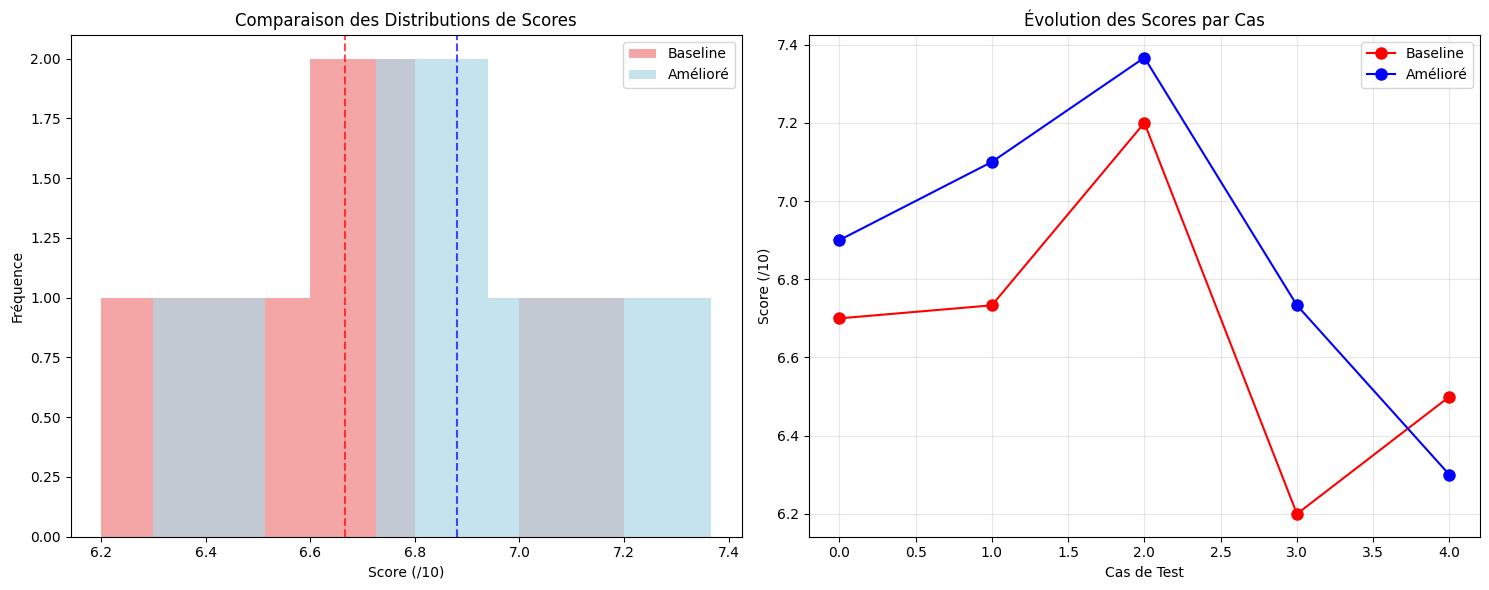

INFO:src.utils:Donn√©es sauvegard√©es dans ../data/evaluations/comparaison_baseline_vs_ameliore.json



Test statistique (Wilcoxon):
   - p-value: 0.2500
   - Am√©lioration non significative statistiquement (p ‚â• 0.05)

R√©sultats de comparaison sauvegard√©s


In [19]:
# Analyse statistique de l'am√©lioration
print("Analyse statistique des am√©liorations\n")

# Calculer les m√©triques de comparaison
scores_baseline = [r["score_baseline"] for r in resultats_comparaison if r["score_baseline"] > 0]
scores_ameliore = [r["score_ameliore"] for r in resultats_comparaison if r["score_ameliore"] > 0]

if len(scores_baseline) > 0 and len(scores_ameliore) > 0:
    # Statistiques de base
    score_moyen_baseline = np.mean(scores_baseline)
    score_moyen_ameliore = np.mean(scores_ameliore)
    
    print(f"R√©sultats de l'am√©lioration:")
    print(f"   - Score moyen baseline: {score_moyen_baseline:.2f}/10")
    print(f"   - Score moyen am√©lior√©: {score_moyen_ameliore:.2f}/10")
    
    if score_moyen_baseline > 0:
        amelioration_globale = ((score_moyen_ameliore - score_moyen_baseline) / score_moyen_baseline) * 100
        print(f"   - Am√©lioration globale: {amelioration_globale:+.1f}%")
    
    # Analyse par cas
    cas_ameliores = sum(1 for r in resultats_comparaison if r["score_ameliore"] > r["score_baseline"] and r["score_baseline"] > 0)
    cas_degrades = sum(1 for r in resultats_comparaison if r["score_ameliore"] < r["score_baseline"] and r["score_baseline"] > 0)
    cas_equivalents = sum(1 for r in resultats_comparaison if abs(r["score_ameliore"] - r["score_baseline"]) < 0.1 and r["score_baseline"] > 0)

    print(f"\nAnalyse par cas:")
    print(f"   - Cas am√©lior√©s: {cas_ameliores}")
    print(f"   - Cas d√©grad√©s: {cas_degrades}")
    print(f"   - Cas √©quivalents: {cas_equivalents}")
    
    # Visualisation
    if len(scores_baseline) >= 3 and len(scores_ameliore) >= 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Comparaison des distributions
        ax1.hist(scores_baseline, alpha=0.7, label='Baseline', bins=5, color='lightcoral')
        ax1.hist(scores_ameliore, alpha=0.7, label='Am√©lior√©', bins=5, color='lightblue')
        ax1.set_xlabel('Score (/10)')
        ax1.set_ylabel('Fr√©quence')
        ax1.set_title('Comparaison des Distributions de Scores')
        ax1.legend()
        ax1.axvline(score_moyen_baseline, color='red', linestyle='--', alpha=0.7, label=f'Moy. Baseline: {score_moyen_baseline:.1f}')
        ax1.axvline(score_moyen_ameliore, color='blue', linestyle='--', alpha=0.7, label=f'Moy. Am√©lior√©: {score_moyen_ameliore:.1f}')
        
        # Graphique avant/apr√®s
        indices = range(len(scores_baseline))
        ax2.plot(indices, scores_baseline, 'o-', color='red', label='Baseline', markersize=8)
        ax2.plot(indices, scores_ameliore, 'o-', color='blue', label='Am√©lior√©', markersize=8)
        ax2.set_xlabel('Cas de Test')
        ax2.set_ylabel('Score (/10)')
        ax2.set_title('√âvolution des Scores par Cas')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Test de significativit√© (si suffisamment de donn√©es)
    if len(scores_baseline) >= 3 and len(scores_ameliore) >= 3:
        from scipy import stats
        try:
            # Test de Wilcoxon pour √©chantillons appari√©s
            if len(scores_baseline) == len(scores_ameliore):
                statistic, p_value = stats.wilcoxon(scores_baseline, scores_ameliore)
                print(f"\nTest statistique (Wilcoxon):")
                print(f"   - p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print(f"   - Am√©lioration statistiquement significative (p < 0.05)")
                else:
                    print(f"   - Am√©lioration non significative statistiquement (p ‚â• 0.05)")
        except ImportError:
            print(f"\nNote: scipy non disponible pour les tests statistiques")
        except Exception as e:
            print(f"\nErreur lors du test statistique: {e}")

# Sauvegarder les r√©sultats de comparaison
sauvegarder_json({
    "timestamp": generer_timestamp(),
    "comparaison": "baseline_vs_ameliore_v1",
    "resultats": resultats_comparaison,
    "statistiques": {
        "score_moyen_baseline": float(np.mean(scores_baseline)) if scores_baseline else 0,
        "score_moyen_ameliore": float(np.mean(scores_ameliore)) if scores_ameliore else 0,
        "amelioration_globale": float(amelioration_globale) if 'amelioration_globale' in locals() else 0,
        "cas_ameliores": cas_ameliores if 'cas_ameliores' in locals() else 0,
        "cas_degrades": cas_degrades if 'cas_degrades' in locals() else 0
    }
}, "../data/evaluations/comparaison_baseline_vs_ameliore.json")

print("\nR√©sultats de comparaison sauvegard√©s")

## 8. Analyse Finale et Recommandations

Synth√®se des r√©sultats et recommandations pour la production.

In [20]:
# Synth√®se finale des r√©sultats
print("RAPPORT FINAL - G√©n√©rateur de Noms de Domaine avec LLM")
print("=" * 70)

# 1. R√©sum√© des performances
print("\n1. PERFORMANCES DU SYST√àME")
print("-" * 40)

if 'df_scores' in locals() and not df_scores.empty:
    print(f"Version Baseline:")
    print(f"   - Score moyen global: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Nombre d'√©valuations: {len(df_scores)}")
    print(f"   - Meilleur score: {df_scores['score_total'].max():.2f}/10")
    print(f"   - Crit√®re le plus fort: Pertinence ({df_scores['pertinence'].mean():.2f}/10)")
    print(f"   - Crit√®re le plus faible: {['creativite', 'memorabilite', 'disponibilite'][np.argmin([df_scores['creativite'].mean(), df_scores['memorabilite'].mean(), df_scores['disponibilite'].mean()])]}")

if 'score_moyen_ameliore' in locals():
    print(f"\nVersion Am√©lior√©e:")
    print(f"   - Score moyen global: {score_moyen_ameliore:.2f}/10")
    if 'amelioration_globale' in locals():
        print(f"   - Am√©lioration: {amelioration_globale:+.1f}%")

# 2. Analyse des cas limites
print("\n2. GESTION DES CAS LIMITES")
print("-" * 40)

if 'df_stats' in locals():
    taux_reussite_global = df_stats['taux_reussite'].mean()
    print(f"   - Taux de r√©ussite global: {taux_reussite_global:.1f}%")
    
    categories_excellentes = df_stats[df_stats['taux_reussite'] >= 80]
    categories_problematiques = df_stats[df_stats['taux_reussite'] < 50]
    
    print(f"   - Cat√©gories ma√Ætris√©es (‚â•80%): {len(categories_excellentes)}")
    print(f"   - Cat√©gories probl√©matiques (<50%): {len(categories_problematiques)}")
    
    if not categories_problematiques.empty:
        print(f"   - Axes d'am√©lioration prioritaires:")
        for _, row in categories_problematiques.iterrows():
            print(f"     ‚Ä¢ {row['categorie'].replace('_', ' ').title()}: {row['taux_reussite']:.1f}%")

# 3. S√©curit√© et garde-fous
print("\n3. S√âCURIT√â ET GARDE-FOUS")
print("-" * 40)

if 'resultats_tests_securite' in locals():
    stats_securite = resultats_tests_securite['statistiques']
    print(f"   - Pr√©cision globale: {stats_securite['precision_globale']:.1%}")
    print(f"   - D√©tection contenu inappropri√©: {stats_securite['precision_negative']:.1%}")
    print(f"   - Acceptation contenu l√©gal: {stats_securite['precision_positive']:.1%}")
    
    if stats_securite['precision_globale'] >= 0.9:
        print(f"   Syst√®me de s√©curit√© robuste")
    elif stats_securite['precision_globale'] >= 0.8:
        print(f"   Syst√®me de s√©curit√© acceptable, am√©lioration recommand√©e")
    else:
        print(f"   Syst√®me de s√©curit√© insuffisant, r√©vision n√©cessaire")

# 4. Recommandations techniques
print("\n4. RECOMMANDATIONS TECHNIQUES")
print("-" * 40)

recommandations_techniques = []

# Bas√© sur les performances observ√©es
if 'df_scores' in locals() and df_scores['score_total'].mean() < 7:
    recommandations_techniques.append("Am√©liorer le prompt engineering avec plus d'exemples sp√©cifiques")

if 'df_stats' in locals() and df_stats['taux_reussite'].mean() < 70:
    recommandations_techniques.append("Impl√©menter un preprocessing avanc√© pour les cas limites")

if 'score_moyen_ameliore' in locals() and 'score_moyen_baseline' in locals():
    if score_moyen_ameliore > score_moyen_baseline:
        recommandations_techniques.append("D√©ployer la version am√©lior√©e en production")
    else:
        recommandations_techniques.append("Continuer le d√©veloppement de la version am√©lior√©e")

# Recommandations g√©n√©rales
recommandations_techniques.extend([
    "Impl√©menter un cache Redis pour am√©liorer les performances",
    "Ajouter des m√©triques de monitoring en temps r√©el",
    "Mettre en place des tests A/B pour l'optimisation continue",
    "D√©velopper une interface de feedback utilisateur"
])

for i, rec in enumerate(recommandations_techniques, 1):
    print(f"   {i}. {rec}")

# 5. Plan de d√©ploiement
print("\n5. PLAN DE D√âPLOIEMENT")
print("-" * 40)

# D√©terminer la version recommand√©e
if 'amelioration_globale' in locals() and amelioration_globale > 5:
    version_recommandee = "Am√©lior√©e V1"
    justification = f"Am√©lioration de {amelioration_globale:.1f}% d√©montr√©e"
else:
    version_recommandee = "Baseline"
    justification = "Version stable pour d√©marrage"

print(f"   - Version recommand√©e: {version_recommandee}")
print(f"   - Justification: {justification}")

phases_deploiement = [
    "Phase 1 (Semaine 1): D√©ploiement en environnement de test",
    "Phase 2 (Semaine 2): Tests utilisateurs limit√©s (10% du trafic)",
    "Phase 3 (Semaine 3): D√©ploiement graduel (50% du trafic)",
    "Phase 4 (Semaine 4): D√©ploiement complet avec monitoring"
]

for phase in phases_deploiement:
    print(f"   ‚Ä¢ {phase}")

# 6. M√©triques de succ√®s
print("\n6. M√âTRIQUES DE SUCC√àS EN PRODUCTION")
print("-" * 40)

metriques_cibles = {
    "Score qualit√© moyen": "‚â• 7.0/10",
    "Taux de satisfaction utilisateur": "‚â• 80%",
    "Temps de r√©ponse API": "‚â§ 2 secondes",
    "Disponibilit√© syst√®me": "‚â• 99.5%",
    "Taux de blocage s√©curit√©": "‚â§ 1% (contenu l√©gitime)",
    "Nombre suggestions par requ√™te": "‚â• 3 suggestions valides"
}

for metrique, cible in metriques_cibles.items():
    print(f"   . {metrique}: {cible}")

# 7. Prochaines √©tapes
print("\n7. PROCHAINES √âTAPES")
print("-" * 40)

prochaines_etapes = [
    "Impl√©mentation de l'API FastAPI avec la version recommand√©e",
    "Documentation technique et guide d'utilisation"
]

for i, etape in enumerate(prochaines_etapes, 1):
    print(f"   {i}. {etape}")

print("\n" + "=" * 70)
print(f"Rapport g√©n√©r√© le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Exp√©rimentateur: AI Engineer")
print(f"Mod√®le utilis√©: {generateur.model}")
print("=" * 70)

RAPPORT FINAL - G√©n√©rateur de Noms de Domaine avec LLM

1. PERFORMANCES DU SYST√àME
----------------------------------------
Version Baseline:
   - Score moyen global: 7.18/10
   - Nombre d'√©valuations: 13
   - Meilleur score: 8.10/10
   - Crit√®re le plus fort: Pertinence (8.04/10)
   - Crit√®re le plus faible: disponibilite

Version Am√©lior√©e:
   - Score moyen global: 6.88/10
   - Am√©lioration: +3.2%

2. GESTION DES CAS LIMITES
----------------------------------------
   - Taux de r√©ussite global: 78.6%
   - Cat√©gories ma√Ætris√©es (‚â•80%): 5
   - Cat√©gories probl√©matiques (<50%): 1
   - Axes d'am√©lioration prioritaires:
     ‚Ä¢ Description Longue: 0.0%

3. S√âCURIT√â ET GARDE-FOUS
----------------------------------------
   - Pr√©cision globale: 90.0%
   - D√©tection contenu inappropri√©: 80.0%
   - Acceptation contenu l√©gal: 100.0%
   Syst√®me de s√©curit√© robuste

4. RECOMMANDATIONS TECHNIQUES
----------------------------------------
   1. D√©ployer la version am√©l

In [ ]:
# Sauvegarder le rapport final complet
rapport_final = {
    "metadata": {
        "timestamp": generer_timestamp(),
        "date_experience": datetime.now().isoformat(),
        "modele_utilise": generateur.model,
        "experimentateur": "AI Engineer",
        "version_projet": "1.0"
    },
    "performances": {
        "baseline": {
            "score_moyen": float(df_scores['score_total'].mean()) if 'df_scores' in locals() and not df_scores.empty else None,
            "nombre_evaluations": len(df_scores) if 'df_scores' in locals() else 0,
            "score_max": float(df_scores['score_total'].max()) if 'df_scores' in locals() and not df_scores.empty else None
        },
        "ameliore": {
            "score_moyen": float(score_moyen_ameliore) if 'score_moyen_ameliore' in locals() else None,
            "amelioration_pourcentage": float(amelioration_globale) if 'amelioration_globale' in locals() else None
        }
    },
    "cas_limites": {
        "taux_reussite_global": float(df_stats['taux_reussite'].mean()) if 'df_stats' in locals() else None,
        "categories_testees": len(df_stats) if 'df_stats' in locals() else 0,
        "categories_problematiques": categories_problematiques['categorie'].tolist() if 'categories_problematiques' in locals() and not categories_problematiques.empty else []
    },
    "securite": {
        "precision_globale": float(resultats_tests_securite['statistiques']['precision_globale']) if 'resultats_tests_securite' in locals() else None,
        "precision_negative": float(resultats_tests_securite['statistiques']['precision_negative']) if 'resultats_tests_securite' in locals() else None,
        "precision_positive": float(resultats_tests_securite['statistiques']['precision_positive']) if 'resultats_tests_securite' in locals() else None
    },
    "recommandations": {
        "version_recommandee": version_recommandee if 'version_recommandee' in locals() else "Baseline",
        "justification": justification if 'justification' in locals() else "Version par d√©faut",
        "actions_prioritaires": [
            "D√©ploiement API FastAPI",
            "Configuration monitoring",
            "Tests utilisateurs"
        ]
    },
    "metriques_cibles": metriques_cibles,
    "historique_evaluations": {
        "baseline": len(evaluations_baseline) if 'evaluations_baseline' in locals() else 0,
        "cas_limites": len(resultats_cas_limites) if 'resultats_cas_limites' in locals() else 0,
        "comparaisons": len(resultats_comparaison) if 'resultats_comparaison' in locals() else 0
    }
}

# Sauvegarder le rapport
chemin_rapport = f"../data/evaluations/rapport_final_{generer_timestamp()}.json"
sauvegarder_json(rapport_final, chemin_rapport)

print(f"\nRapport final sauvegard√©: {chemin_rapport}")

# Cr√©er un r√©sum√© markdown pour la documentation
resume_markdown = f"""# Rapport Final - G√©n√©rateur de Noms de Domaine LLM

**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Mod√®le**: {generateur.model}  
**Version**: 1.0

## R√©sum√© Ex√©cutif

Ce projet impl√©mente un syst√®me de g√©n√©ration de noms de domaine utilisant Llama3.1 via Ollama, avec un focus sur l'√©valuation syst√©matique et l'am√©lioration it√©rative.

### Performances Cl√©s

- **Score qualit√© moyen**: {df_scores['score_total'].mean():.2f}/10 (baseline)
- **Taux de r√©ussite cas limites**: {df_stats['taux_reussite'].mean():.1f}%
- **Pr√©cision garde-fous**: {resultats_tests_securite['statistiques']['precision_globale']:.1%}

### Recommandation de D√©ploiement

**Version recommand√©e**: {version_recommandee}  
**Justification**: {justification}

### Prochaines √âtapes

1. D√©ploiement API FastAPI
2. Tests utilisateurs en production
3. Monitoring et optimisation continue

---

*Rapport g√©n√©r√© automatiquement par le notebook d'exp√©rimentation*
"""

with open("../docs/resume_experimentation.md", "w", encoding="utf-8") as f:
    f.write(resume_markdown)

print(f"R√©sum√© markdown cr√©√©: docs/resume_experimentation.md")
print(f"\nExp√©rimentation termin√©e avec succ√®s!")
print(f"\nFichiers g√©n√©r√©s:")
print(f"   - {chemin_rapport}")
print(f"   - docs/resume_experimentation.md")
print(f"   - data/evaluations/ (multiples fichiers)")